In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline
import random
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

C:\Users\Sai Tehith\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
clear_frames = 'C:/Users/Sai Tehith/Downloads/major/data1/train/HR'
bad_frames = 'C:/Users/Sai Tehith/Downloads/major/data1/train/LR'

In [3]:
clean_frames = []
for file in tqdm(sorted(os.listdir(clear_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(clear_frames + '/' + file, target_size=(250,250))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
blur_factor=5
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(250,250))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255


        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 31.98it/s]


In [4]:
class_names = ['HR','LR']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (250,250)

In [5]:
#C:\Users\onlin\Downloads\archive\dataset
def load_data():

    datasets = ['C:/Users/Sai Tehith/Downloads/major/data1/train', 'C:/Users/Sai Tehith/Downloads/major/data1/test']

    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))
        for i in range(3):
            r = random.randint(0, len(clean_frames)-1)
            m, result = blurry_frames[r],clean_frames[r]

    return output


In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/Sai Tehith/Downloads/major/data1/train


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:03<00:00, 26.16it/s]


Loading C:/Users/Sai Tehith/Downloads/major/data1/test


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:03<00:00, 24.74it/s]


49


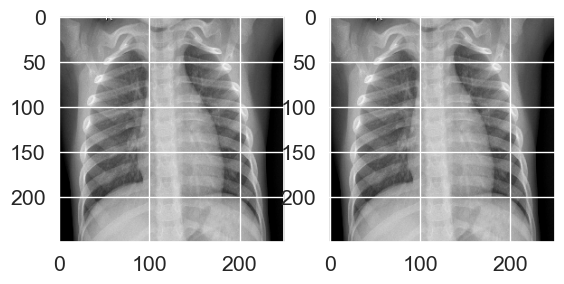

In [7]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 176
Number of testing examples: 176
Each image is of size: (250, 250)


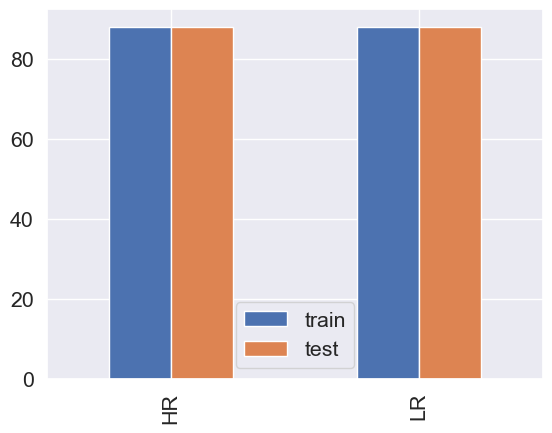

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
def display_examples(class_names, images, labels):


    fig = plt.figure(figsize=(10,10))
    fig.suptitle("images of the dataset", fontsize=16)
    for i in range(5):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

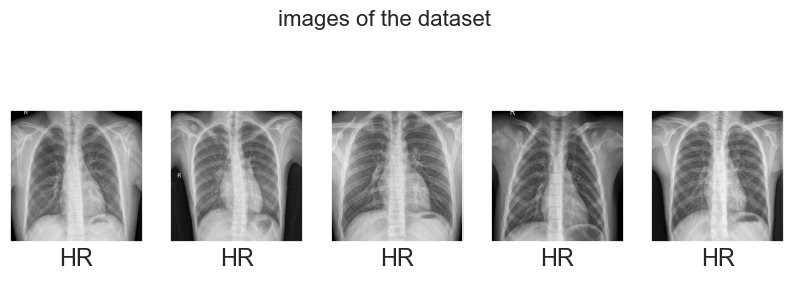

In [12]:
display_examples(class_names, train_images, train_labels)

In [13]:
#Generator
input_shape = (250,250, 3)
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model
class SubpixelConv2D(Layer):


    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor


    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )
# Network Parameters
input_shape = (250,250, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs
def get_G(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)
    relu= Activation('relu')

    nin= Input(shape= input_shape)
    n= Conv2D(64, (3,3), padding='SAME', activation= 'relu',
                        kernel_initializer='HeNormal')(nin)
    temp= n


    # B residual blocks
    for i in range(3):
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)
        nn= relu(nn)
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)

        nn= add([n, nn])
        n= nn

    n= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= add([n, temp])
    # B residual blacks end

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    nn= Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(n)


    G = Model(inputs=nin, outputs=nn, name="generator")
    return G
get_G(input_shape)

# discriminator
def get_D(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)
    ly_relu= LeakyReLU(alpha= 0.2)
    df_dim = 16

    nin = Input(input_shape)
    n = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(nin)
    n= ly_relu(n)

    for i in range(2, 6):
        n = Conv2D(df_dim*(2**i),(4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(n)
        n= ly_relu(n)
        n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    temp= n

    n= Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= add([n, temp])

    n= Flatten()(n)
    no= Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(n)
    D= Model(inputs=nin, outputs=no, name="discriminator")

    return D
for i in range(3):

        r = random.randint(0, len(clean_frames)-1)
        m, result = blurry_frames[r],clean_frames[r]

get_D(input_shape)
# VGG19
def get_vgg19():
    vgg= tf.keras.applications.VGG19( include_top=False, weights='imagenet',
                                    input_tensor=None, input_shape=(384, 384, 3),
                                    pooling=None, classes=1000, classifier_activation='softmax' )

    inp= Input(shape=(250,250, 3))
    x= vgg.layers[0](inp)
    for ly in vgg.layers[1:17]:
        x= ly(x)
    VGG19= Model(inp, x)

    return VGG19
def  gan():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (250, 250, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(88, activation=tf.nn.relu),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=50, epochs=30, validation_split = 0.46)
    model.save('modelg.h5')
    get_vgg19()
gan()

Epoch 1/30
2/2 [==============================] - 11s 4s/step - loss: 1.3704 - accuracy: 0.9263 - val_loss: 53.9086 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 5s 3s/step - loss: 4.0433 - accuracy: 0.9263 - val_loss: 33.3655 - val_accuracy: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 2.2782 - accuracy: 0.9263 - val_loss: 14.1595 - val_accuracy: 0.0000e+00
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 1.0002 - accuracy: 0.9263 - val_loss: 3.7899 - val_accuracy: 0.0000e+00
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 0.2411 - accuracy: 0.9263 - val_loss: 1.1045 - val_accuracy: 0.0000e+00
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 0.4730 - accuracy: 0.9263 - val_loss: 1.1247 - val_accuracy: 0.0000e+00
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 0.3920 - accuracy: 0.9368 - val_loss: 2.2539 - val_accuracy: 0.0000e+00
Epoch 8/3

C:\Users\Sai Tehith\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



       Input LR image                       HR image        result 
1/1 [==============================] - 0s 100ms/step


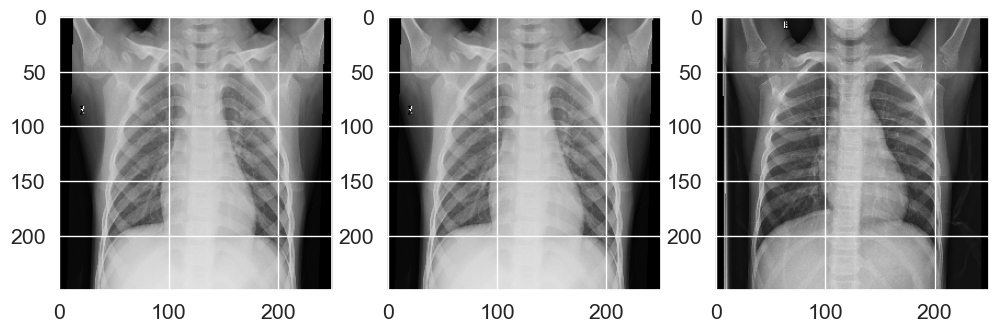

In [18]:
print("\n       Input LR image                       HR image        result ")
for i in range(1):

    r = random.randint(0, len(clean_frames)-1)

    model = tf.keras.models.load_model('modelg.h5')
    x, y = blurry_frames[r],clean_frames[r]

    x_inp=x.reshape(1,250,250,3)

    resu1t = model.predict(x_inp)



    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(result)


In [15]:
#model.save_weights("model_vgg.h5")
#print("Saved model to disk")

In [16]:
model_json=model.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import tensorflow as tf
from flask import Flask, render_template, request, send_from_directory

app = Flask(__name__)


UPLOAD_FOLDER = "uploads"
STATIC_FOLDER = "static"
json_file = open('model_vgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
cnn_model = model_from_json(loaded_model_json)
# load weights into new model
cnn_model.load_weights("modelg.h5")
# Load model

IMAGE_SIZE = 250

# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range

    return image


# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)

    return preprocess_image(image)


# Predict & classify image
def classify(model, image_path):

    preprocessed_imgage = load_and_preprocess_image(image_path)
    preprocessed_imgage = tf.reshape(
        preprocessed_imgage, (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    prob = model.predict(preprocessed_imgage)
    label = "HR" if prob[0][0] >= 0.5 else "LR"
    classified_prob = prob[0][0] if prob[0][0] >= 0.5 else 1 - prob[0][0]

    return label, classified_prob


# home page
@app.route("/")
def home():
    return render_template("home.html")


@app.route("/classify", methods=["POST", "GET"])
def upload_file():

    if request.method == "GET":
        return render_template("home.html")

    else:
        file = request.files["image"]
        upload_image_path = os.path.join(UPLOAD_FOLDER, file.filename)
        print(upload_image_path)
        file.save(upload_image_path)

        label, prob = classify(model, upload_image_path)

        prob = round((prob * 100), 2)

    return render_template(
        "classify.html", image_file_name=file.filename, label=label, prob=prob
    )


@app.route("/classify/<filename>")
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)


if __name__ == "__main__":

    app.run()



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Mar/2024 18:15:19] "GET / HTTP/1.1" 200 -


uploads\NORMAL2-IM-0051-0001.jpeg
1/1 [==============================] - 0s 43ms/step


127.0.0.1 - - [25/Mar/2024 18:15:28] "POST /classify HTTP/1.1" 200 -
